<div align="center">

###### Lab 2

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 2: Predicting Heart Disease with Deep Learning

</div>

### Introduction

In the realm of healthcare, early detection and accurate prediction of diseases play a crucial role in patient care and management. Heart disease remains one of the leading causes of mortality worldwide, making the development of effective diagnostic tools essential. This lab leverages deep learning to predict the presence of heart disease in patients using a subset of 14 key attributes from the Cleveland Heart Disease Database. The objective is to explore and apply deep learning techniques to distinguish between the presence and absence of heart disease based on clinical parameters.

Throughout this lab, you'll engage with the following key activities:
- Use [Pandas](https://pandas.pydata.org) to process the CSV files.
- Use [PyTorch](https://pytorch.org) to build an Artificial Neural Network (ANN) to fit the dataset.
- Evaluate the performance of the trained model to understand its accuracy.

### Attribute Information

1. age: Age of the patient in years
2. sex: (Male/Female)
3. cp: Chest pain type (4 types: low, medium, high, and severe)
4. trestbps: Resting blood pressure
5. chol: Serum cholesterol in mg/dl
6. fbs: Fasting blood sugar > 120 mg/dl
7. restecg: Resting electrocardiographic results (values 0,1,2)
8. thalach: Maximum heart rate achieved
9. exang: Exercise induced angina
10. oldpeak: Oldpeak = ST depression induced by exercise relative to rest
11. slope: The slope of the peak exercise ST segment
12. ca: Number of major vessels (0-3) colored by fluoroscopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversible defect
14. target: target have disease or not (1=yes, 0=no)

### References
- [UCI Heart Disease Data](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data) for the dataset we use in this lab.


In [42]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
import matplotlib.pyplot as plt
import random

In [43]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [44]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # 保證可重現性
    torch.backends.cudnn.benchmark = False     # 但可能會稍微降低速度

# 設定種子
set_seed(42)

## A. Checking and Preprocessing

In [ ]:
df = pd.read_csv('./heart_dataset_train_all.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,41,Male,medium,105.0,198.0,0,1.0,168.0,0,0.0,2.0,1,2.0,1.0
1,65,Female,low,120.0,177.0,0,1.0,140.0,0,0.4,2.0,0,3.0,1.0
2,44,Female,medium,130.0,219.0,0,0.0,188.0,0,0.0,2.0,0,2.0,1.0
3,54,Female,high,125.0,273.0,0,0.0,152.0,0,0.5,0.0,1,2.0,1.0
4,51,Female,severe,125.0,213.0,0,0.0,125.0,1,1.4,2.0,1,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,40,Female,low,110.0,167.0,0,0.0,114.0,1,2.0,1.0,0,3.0,0.0
269,60,Female,low,117.0,230.0,1,1.0,160.0,1,1.4,2.0,2,3.0,0.0
270,64,Female,high,140.0,335.0,0,1.0,158.0,0,0.0,2.0,0,2.0,0.0
271,43,Female,low,120.0,177.0,0,0.0,120.0,1,2.5,1.0,0,3.0,0.0


In [46]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       273 non-null    int64  
 1   sex       272 non-null    object 
 2   cp        272 non-null    object 
 3   trestbps  272 non-null    float64
 4   chol      271 non-null    float64
 5   fbs       273 non-null    int64  
 6   restecg   272 non-null    float64
 7   thalach   272 non-null    float64
 8   exang     273 non-null    int64  
 9   oldpeak   273 non-null    float64
 10  slope     271 non-null    float64
 11  ca        273 non-null    int64  
 12  thal      272 non-null    float64
 13  target    272 non-null    float64
dtypes: float64(8), int64(4), object(2)
memory usage: 30.0+ KB


In [48]:
# checking for null values
df.isnull().sum()

age         0
sex         1
cp          1
trestbps    1
chol        2
fbs         0
restecg     1
thalach     1
exang       0
oldpeak     0
slope       2
ca          0
thal        1
target      1
dtype: int64

In [49]:
df = df.dropna()

In [50]:
df.shape

(270, 14)

In [51]:
# Mapping 'sex' descriptions to numbers
sex_description = {
    'Male': 0,
    'Female': 1,
}
df.loc[:, 'sex'] = df['sex'].map(sex_description)

# Mapping 'cp' (chest pain) descriptions to numbers
pain_description = {
    'low': 0,
    'medium': 1,
    'high': 2,
    'severe': 3
}
df.loc[:, 'cp'] = df['cp'].map(pain_description)

df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,41,0,1,105.0,198.0,0,1.0,168.0,0,0.0,2.0,1,2.0,1.0
1,65,1,0,120.0,177.0,0,1.0,140.0,0,0.4,2.0,0,3.0,1.0
2,44,1,1,130.0,219.0,0,0.0,188.0,0,0.0,2.0,0,2.0,1.0
3,54,1,2,125.0,273.0,0,0.0,152.0,0,0.5,0.0,1,2.0,1.0
4,51,1,3,125.0,213.0,0,0.0,125.0,1,1.4,2.0,1,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,40,1,0,110.0,167.0,0,0.0,114.0,1,2.0,1.0,0,3.0,0.0
269,60,1,0,117.0,230.0,1,1.0,160.0,1,1.4,2.0,2,3.0,0.0
270,64,1,2,140.0,335.0,0,1.0,158.0,0,0.0,2.0,0,2.0,0.0
271,43,1,0,120.0,177.0,0,0.0,120.0,1,2.5,1.0,0,3.0,0.0


In [52]:
df.describe()

,age,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,54.385185,131.525926,245.607407,0.151852,0.522222,149.807407,0.333333,1.024074,1.400000,0.744444,2.300000,0.544444
std,9.149713,17.904675,51.529411,0.359544,0.529314,23.217253,0.472280,1.188379,0.618188,1.037166,0.623874,0.498946
min,29.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.250000,120.000000,210.250000,0.000000,0.000000,134.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.600000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,140.000000,274.000000,0.000000,1.000000,167.750000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [53]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.062222,-0.103697,0.261782,0.210520,0.109847,-0.124588,-0.412624,0.111263,0.200243,-0.165360,0.254462,0.077368,-0.244798
sex,-0.062222,1.000000,-0.040197,-0.055463,-0.166885,0.042384,-0.069599,-0.058626,0.124054,0.089726,-0.038771,0.140795,0.198493,-0.283776
cp,-0.103697,-0.040197,1.000000,0.035563,-0.063592,0.065869,0.008389,0.300307,-0.428233,-0.183616,0.135174,-0.180598,-0.139765,0.425574
trestbps,0.261782,-0.055463,0.035563,1.000000,0.128444,0.170606,-0.145195,-0.056631,0.067116,0.184896,-0.126553,0.093545,0.068690,-0.173239
chol,0.210520,-0.166885,-0.063592,0.128444,1.000000,0.003430,-0.162687,-0.023753,0.063902,0.084355,-0.031929,0.068647,0.121280,-0.096773
fbs,0.109847,0.042384,0.065869,0.170606,0.003430,1.000000,-0.086165,-0.014297,0.029190,0.007943,-0.056866,0.164266,-0.004972,-0.068845
restecg,-0.124588,-0.069599,0.008389,-0.145195,-0.162687,-0.086165,1.000000,0.025457,-0.089225,-0.047837,0.074982,-0.053946,-0.003377,0.101817
thalach,-0.412624,-0.058626,0.300307,-0.056631,-0.023753,-0.014297,0.025457,1.000000,-0.404349,-0.340564,0.370073,-0.205060,-0.078637,0.432687
exang,0.111263,0.124054,-0.428233,0.067116,0.063902,0.029190,-0.089225,-0.404349,1.000000,0.294308,-0.280124,0.106250,0.189253,-0.457502
oldpeak,0.200243,0.089726,-0.183616,0.184896,0.084355,0.007943,-0.047837,-0.340564,0.294308,1.000000,-0.585472,0.223375,0.200315,-0.443504


#### Converting the DataFrame to a NumPy Array

In [54]:
import numpy as np

np_data = df.values
np_data.shape

(270, 14)

In [55]:
## 資料切分

split_point = [int(np_data.shape[0]*0.7), int(np_data.shape[0]*0.9)]

np.random.shuffle(np_data)

x_train = np_data[:split_point[0], :13]
y_train = np_data[:split_point[0], 13]

x_val = np_data[split_point[0]:split_point[1], :13]
y_val = np_data[split_point[0]:split_point[1], 13]

x_test = np_data[split_point[1]:, :13]
y_test = np_data[split_point[1]:, 13]

In [56]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
x_train = np.array(x_train.tolist(), dtype=np.float32)
x_train = torch.from_numpy(x_train).float()

# 先把 y_train 轉成 numpy 整數陣列
y_train = np.asarray(y_train, dtype=np.int64)
y_train = torch.from_numpy(y_train).long()

x_val = np.asarray(x_val, dtype=np.float32)
x_val = torch.from_numpy(x_val).float()

y_val = np.asarray(y_val, dtype=np.int64)
y_val = torch.from_numpy(y_val).long()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

Number of samples in train and validation are 189 and 54.


In [57]:
# read test file
test_data = pd.read_csv('./heart_dataset_test.csv')
test_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,50,0,2,120,219,0,1,158,0,1.6,1,0,2,1
1,58,0,2,120,340,0,1,172,0,0.0,2,0,2,1
2,66,0,3,150,226,0,1,114,0,2.6,0,0,2,1
3,43,1,0,150,247,0,1,171,0,1.5,2,0,2,1
4,69,0,3,140,239,0,1,151,0,1.8,2,2,2,1


In [58]:
test_data = test_data.values
# Convert to PyTorch tensors
x_test = torch.from_numpy(test_data[:, :13]).float()
y_test = torch.from_numpy(test_data[:, 13]).long()

# Create datasets
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## B. Defining Neural Networks

In PyTorch, we can use **class** to define our custom neural network architectures by subclassing the `nn.Module` class. This gives our neural network all the functionality it needs to work with PyTorch's other utilities and keeps our implementation organized.

- Neural networks are defined by subclassing `nn.Module`.
- The layers of the neural network are initialized in the `__init__` method.
- The forward pass operations on input data are defined in the `forward` method.

It's worth noting that while we only define the forward pass, PyTorch will automatically derive the backward pass for us, which is used during training to update the model's weights."

In [59]:
import torch.nn as nn

'''
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(13, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        ).cuda()

    def forward(self, x):
        return self.model(x)
'''

class Model(nn.Module):
    def __init__(self, input_dim = 13, hidden_dim = 128, num_hidden_layers = 2, output_dim = 2):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]

        for _ in range(num_hidden_layers-1):

            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dim, output_dim))

        self.model = nn.Sequential(*layers).cuda()
    
    def forward(self, x):
        return self.model(x)

## C. Training the Neural Network

In [60]:
# Check your GPU status.
!nvidia-smi

Mon Mar 24 15:35:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   52C    P8             22W /  370W |    1143MiB /  24576MiB |     20%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [61]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

option = []
train_loss_each_option = []
train_acc_each_option = []
val_loss_each_option = []
val_acc_each_option = []
test_losses_each_option = []
test_acc_each_option = []

val_best_index_list = []


for num_layers in [2,3,4]:
    for lr_option in [1e-2, 1e-3, 1e-4]:

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        best_val_index = 0

        epochs = 100

        model = Model(num_hidden_layers=num_layers)
        model.to(device)
        # print(model)

        best_val_loss = float('inf')
        best_val_acc = -1

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr_option)
        lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

        for epoch in tqdm(range(epochs)):
            # Training
            model.train()
            total_loss = 0.0
            train_correct = 0
            total_train_samples = 0

            for features, labels in train_loader:
                features = features.cuda()
                labels = labels.cuda()

                outputs = model(features)

                loss = criterion(outputs, labels)
                total_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_predicted = outputs.argmax(-1)
                train_correct += (train_predicted == labels).sum().item()
                total_train_samples += labels.size(0)

            # Learning rate update
            lr_scheduler.step()

            avg_train_loss = total_loss / len(train_loader)
            train_accuracy = 100. * train_correct / total_train_samples

            # Validation
            model.eval()
            total_val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for features, labels in val_loader:
                    features = features.cuda()
                    labels = labels.cuda()

                    outputs = model(features)

                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()

                    predicted = outputs.argmax(-1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

            avg_val_loss = total_val_loss / len(val_loader)
            val_accuracy = 100. * correct / total

            # Checkpoint
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss

            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                torch.save(model.state_dict(), 'model_classification.pth')
                best_val_index = len(val_accuracies)

            #print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

            # Store performance
            train_losses.append(avg_train_loss)
            train_accuracies.append(train_accuracy)
            val_losses.append(avg_val_loss)
            val_accuracies.append(val_accuracy)
            
        val_best_index_list.append(best_val_index)

        option.append(tuple([num_layers, lr_option]))
        train_loss_each_option.append(train_losses)
        train_acc_each_option.append(train_accuracies)
        val_loss_each_option.append(val_losses)
        val_acc_each_option.append(val_accuracies)

        ## Testing
        # Load the trained weights
        model.load_state_dict(torch.load('model_classification.pth'))

        # Set the model to evaluation mode
        model.eval()

        test_correct = 0
        test_total = 0
        total_test_loss = 0

        with torch.no_grad():
            for features, labels in test_loader:

                features = features.cuda()
                labels = labels.cuda()

                outputs = model(features)

                loss = criterion(outputs, labels)
                total_test_loss += loss.item()

                predicted = outputs.argmax(-1)
                test_correct += (predicted == labels).sum().item()
                test_total += labels.size(0)

        test_losses_each_option.append(total_test_loss)
        test_acc_each_option.append(100. * test_correct / test_total)

        #print(f'Test accuracy is {100. * test_correct / test_total}%')

            

100%|██████████| 100/100 [00:01<00:00, 94.06it/s]
C:\Users\113034507\AppData\Local\Temp\ipykernel_17984\1485574153.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mode

#### Visualizing the model performance

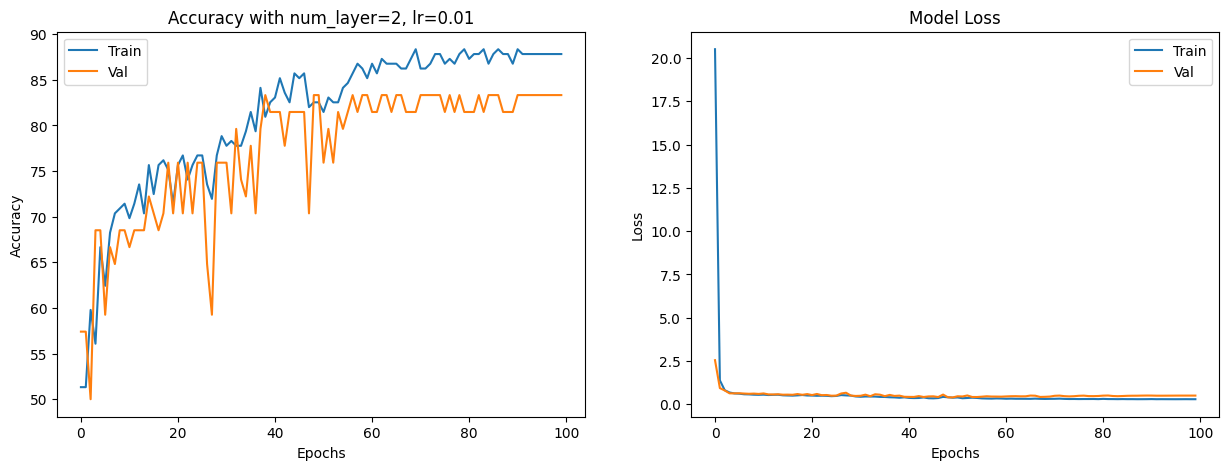

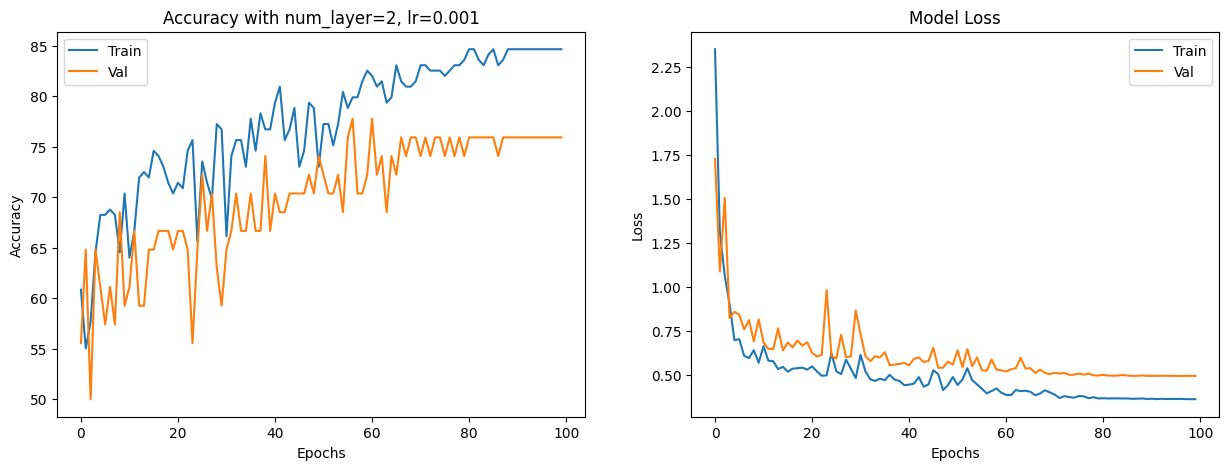

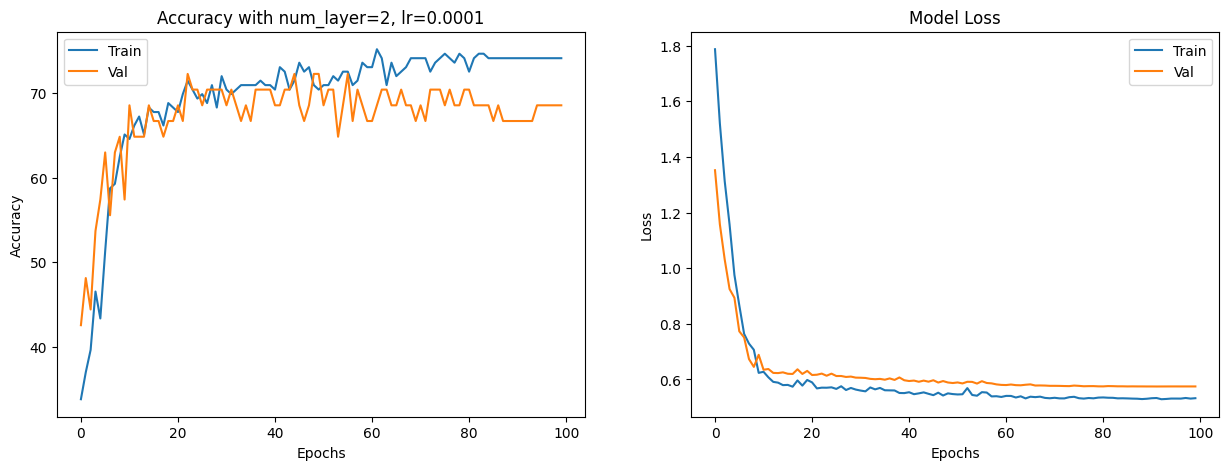

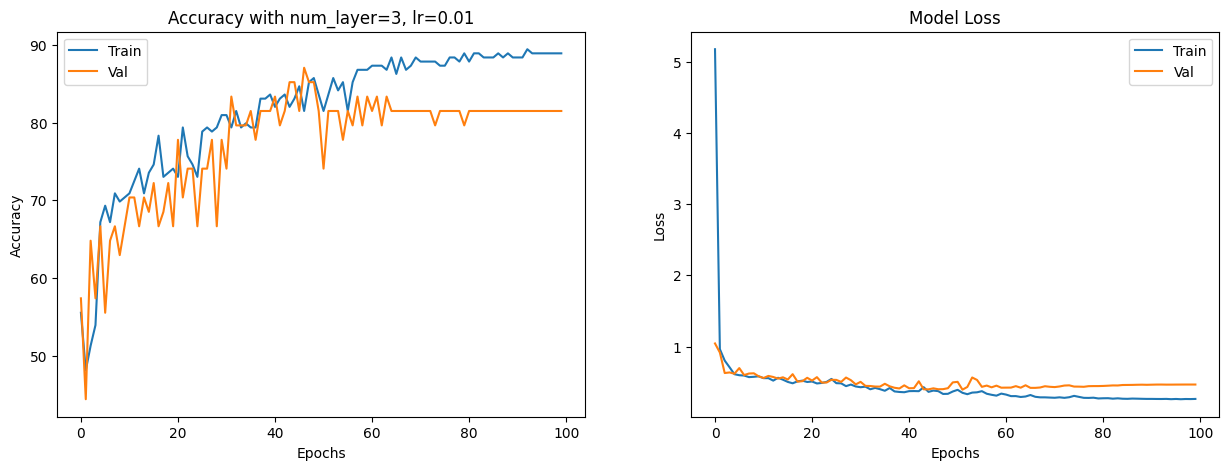

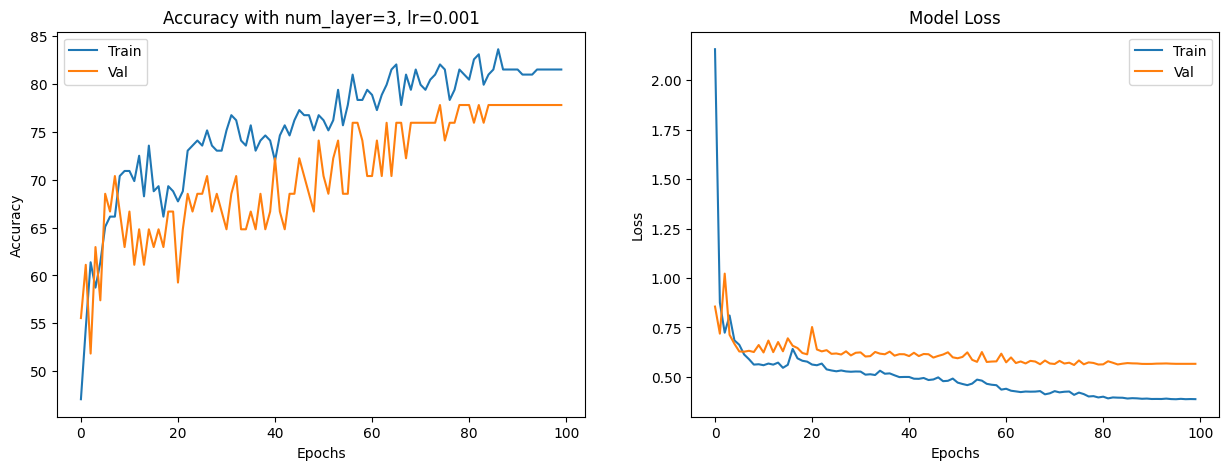

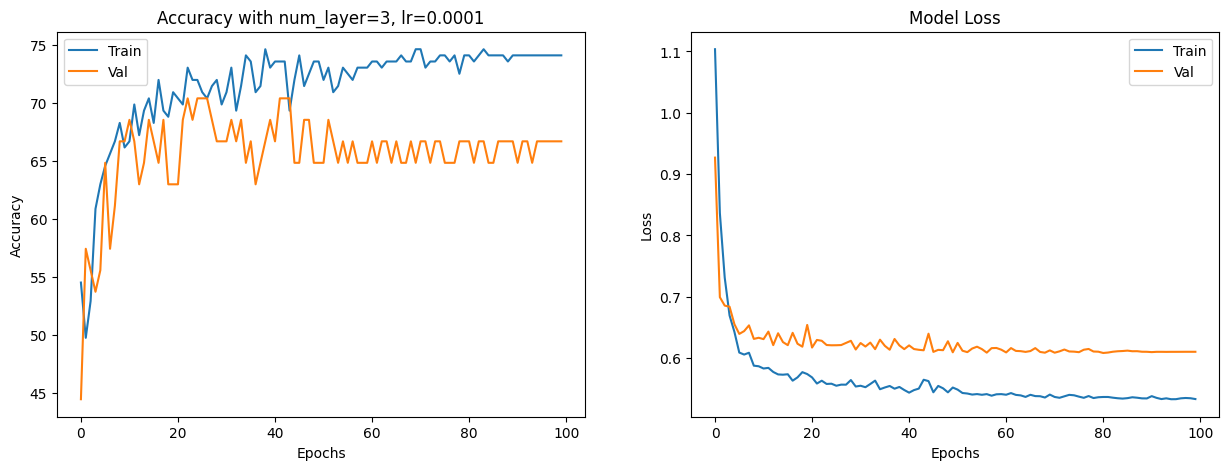

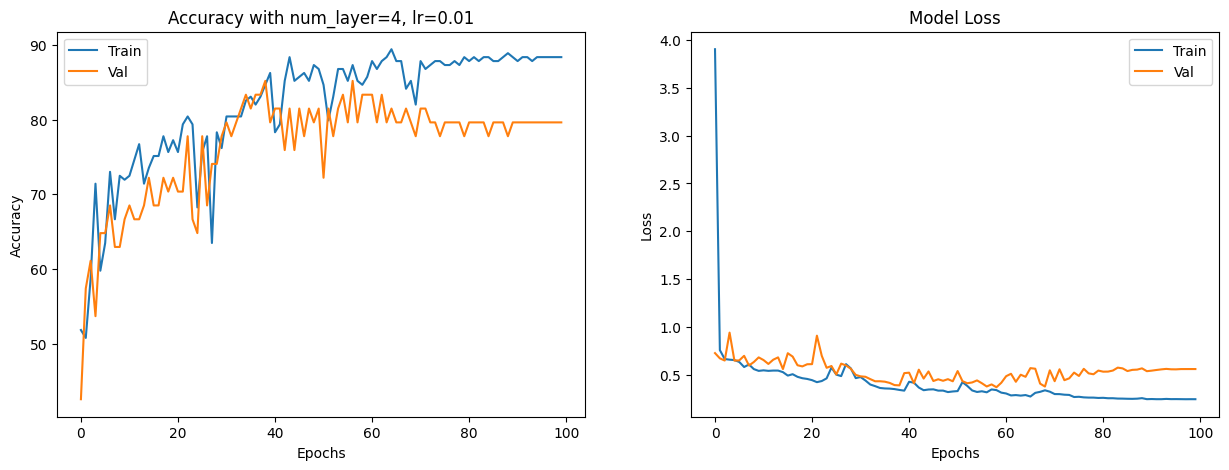

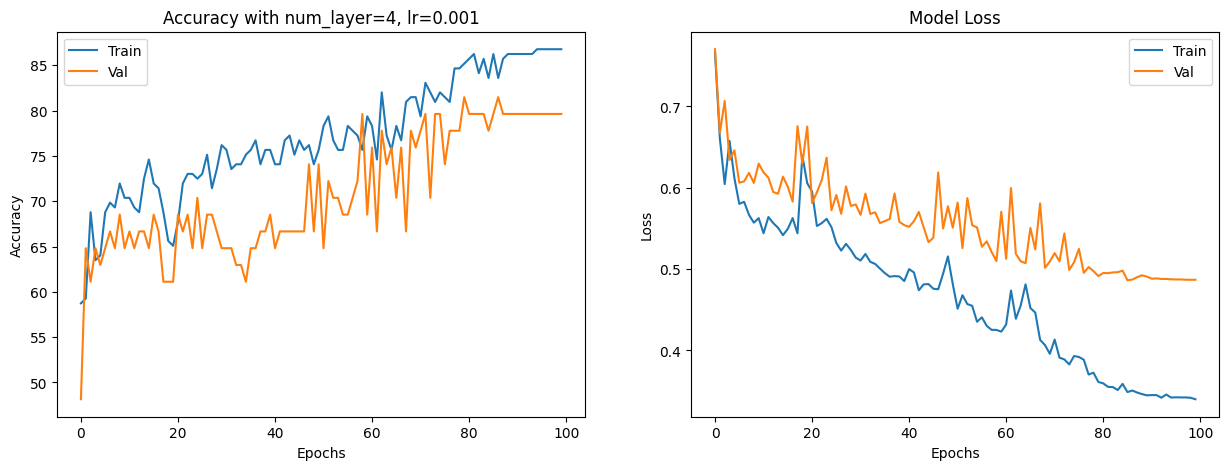

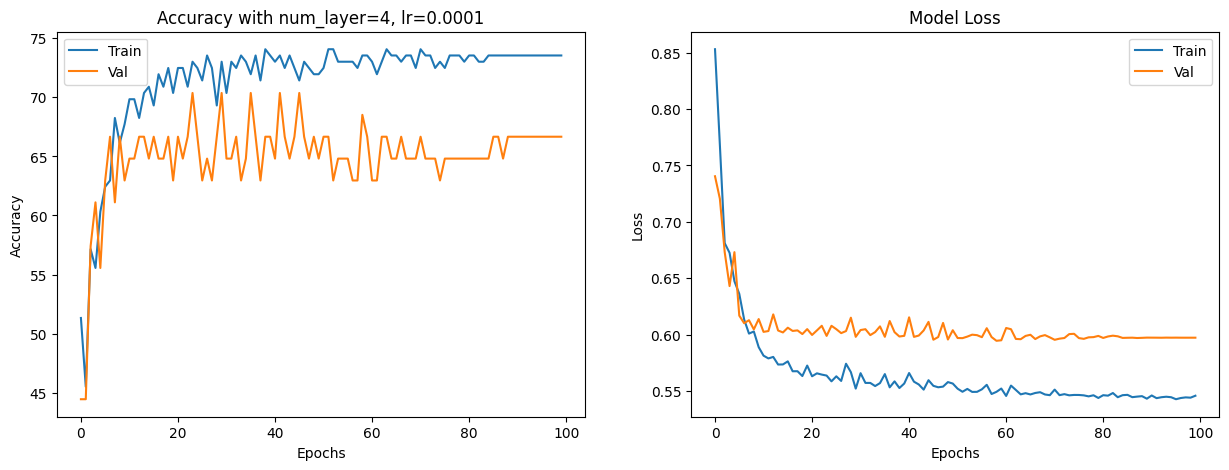

In [62]:
for combination in range(len(train_loss_each_option)):

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Plotting training and validation accuracy
    ax[0].plot(train_acc_each_option[combination])
    ax[0].plot(val_acc_each_option[combination])
    ax[0].set_title(f'Accuracy with num_layer={option[combination][0]}, lr={option[combination][1]}')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(['Train', 'Val'])

    # Plotting training and validation loss
    ax[1].plot(train_loss_each_option[combination])
    ax[1].plot(val_loss_each_option[combination])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['Train', 'Val'])

    plt.show()

In [64]:

result = pd.DataFrame()
result["Combination"] = option
result["best_epoch"] = val_best_index_list
result["train_loss"] = [round(train_loss_each_option[i][val_best_index_list[i]], 2) for i in range(len(option))]
result["train_accuracy"] = [round(train_acc_each_option[i][val_best_index_list[i]], 2) for i in range(len(option))]
result["val_loss"] = [round(val_loss_each_option[i][val_best_index_list[i]], 2) for i in range(len(option))]
result["val_accuracy"] = [round(val_acc_each_option[i][val_best_index_list[i]], 2) for i in range(len(option))]
result["test_loss"] = [round(test_losses_each_option[i], 2) for i in range(len(option))]
result["test_accuracy"] = [round(test_acc_each_option[i], 2) for i in range(len(option))]
result

,Combination,best_epoch,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy
0,"(2, 0.01)",38,0.38,80.95,0.50,83.33,15.49,67.74
1,"(2, 0.001)",56,0.40,79.89,0.53,77.78,15.61,70.97
2,"(2, 0.0001)",22,0.57,71.43,0.62,72.22,19.87,64.52
3,"(3, 0.01)",46,0.37,81.48,0.40,87.04,13.74,70.97
4,"(3, 0.001)",74,0.41,82.01,0.56,77.78,17.80,74.19
5,"(3, 0.0001)",22,0.56,73.02,0.63,70.37,20.86,61.29
6,"(4, 0.01)",38,0.34,84.66,0.39,85.19,14.95,70.97
7,"(4, 0.001)",79,0.36,85.19,0.49,81.48,16.67,74.19
8,"(4, 0.0001)",23,0.56,73.02,0.60,70.37,20.83,64.52


## D. Evaluating Your Trained Model

In [ ]:
# read test file
test_data = pd.read_csv('./heart_dataset_test.csv')
test_data.head()

In [ ]:
test_data.isnull().sum()

In [ ]:
test_data = test_data.values
test_data.shape

In [ ]:
# Convert to PyTorch tensors
x_test = torch.from_numpy(test_data[:, :13]).float()
y_test = torch.from_numpy(test_data[:, 13]).long()

# Create datasets
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for features, labels in test_loader:

        features = features.cuda()
        labels = labels.cuda()

        outputs = model(features)

        predicted = outputs.argmax(-1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')